This dataset shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour. In this period 5 anomalies are present, in term of deviation from a normal behavior. They occur respectively during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.
goal is to detect the anomalies in the best way possible.

In [2]:
# !conda install tensorflow keras pandas seaborn

In [3]:
# !conda install seaborn -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/zhigao/opt/anaconda3/envs/py37_tensorflow

  added / updated specs:
    - seaborn


The following NEW packages will be INSTALLED:

  seaborn            pkgs/main/noarch::seaborn-0.11.2-pyhd3eb1b0_0

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2021.10.~ --> pkgs/main::ca-certificates-2021.10.26-hecd8cb5_2
  certifi            conda-forge::certifi-2021.10.8-py37hf~ --> pkgs/main::certifi-2021.10.8-py37hecd8cb5_2
  openssl            conda-forge::openssl-1.1.1l-h0d85af4_0 --> pkgs/main::openssl-1.1.1m-hca72f7f_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas:  1.3.5
numpy:  1.21.2
seaborn:  0.11.2
matplotlib:  3.5.0
sklearn:  1.0.2
Keras:  2.3.1
Tensorflow:  2.0.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [3]:
base_path = "../"


tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']


dataFilePaths = [base_path + dataFilePaths[i] for i in range(len(dataFilePaths))]

In [4]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  nyc_taxi
dataFilePath:  ../data/nyc_taxi.csv


In [5]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
print(df.head(5))


Shape: 10320
Head:
             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


# Time serials Explore

             timestamp  value            Datetime
0  2014-07-01 00:00:00  10844 2014-07-01 00:00:00
1  2014-07-01 00:30:00   8127 2014-07-01 00:30:00
2  2014-07-01 01:00:00   6210 2014-07-01 01:00:00


Text(0.5, 1.0, 'Time Series of value by date time')

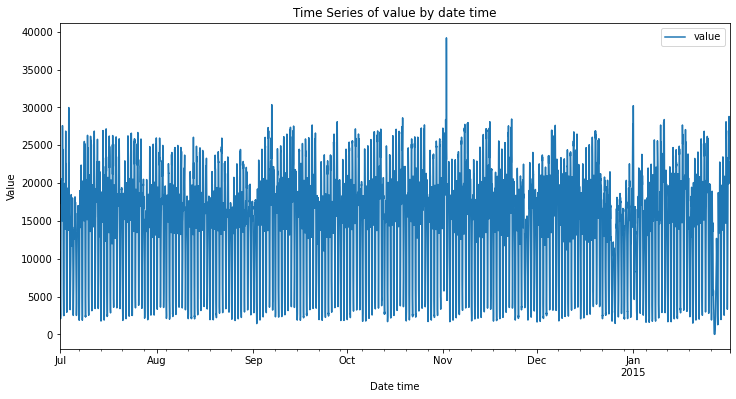

In [6]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
print(df.head(3))
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [8]:
df.value.describe()

count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64

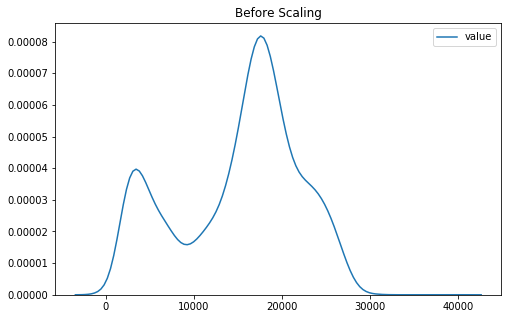

In [9]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

<AxesSubplot:xlabel='value', ylabel='Count'>

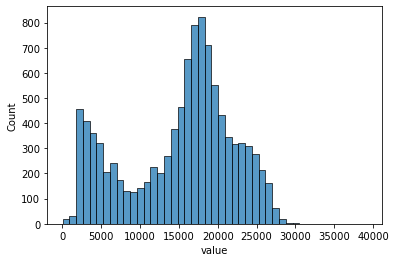

In [35]:
sns.histplot(df['value'])

## Scale

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])
df.head(5)

Shape: 10320


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


<AxesSubplot:title={'center':'After Scaling'}, xlabel='scaled_value', ylabel='Density'>

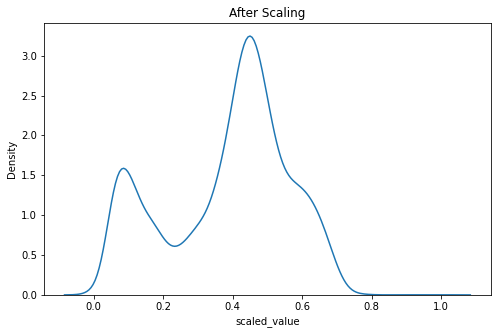

In [8]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [9]:
df.head(5)

,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


# Modelling  LSTM Autoencoder

## Build model

In [10]:
time_steps = 48
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

2022-02-20 21:28:15.026002: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 21:28:15.026405: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 32)            4352      
_________________________________________________________________
dense_1 (Dense)              (None, 48, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


## build data set

In [16]:
sequence.shape

(10320,)

In [17]:
sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 48
samples = len(sequence)

trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(sequence_trimmed.shape)
print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]
(10320,)
10320 215
(215, 48, 1)


In [18]:
# sequence_trimmed

## Train 

In [63]:
training_dataset = sequence_trimmed
print("training_dataset: ", training_dataset.shape)

batch_size=32
epochs=20


training_dataset:  (215, 48, 1)


## Plot training 

In [69]:
training_dataset.shape

(215, 48, 1)

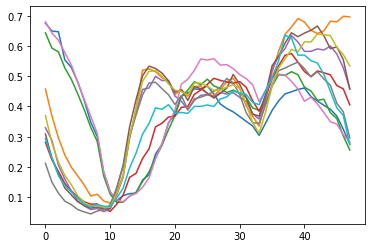

In [72]:
import random
for i in range(0,10):
    r = random.randint(0,training_dataset.shape[0]-1)
    plt.plot(training_dataset[r])

    # plt.plot(training_dataset[])

## Train model with same input and output

In [ ]:

model.fit(x=training_dataset, y=training_dataset,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, validation_data=(training_dataset, training_dataset),
                       callbacks=[TensorBoard(log_dir='../logs/{0}'.format(tensorlog))])

## Evaluate

In [56]:
import math
from sklearn.metrics import mean_squared_error

sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 48
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

testing_dataset = sequence_trimmed
print("testing_dataset: ", testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print("testing_dataset: ", testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print("testing_pred: ", testing_pred.shape)
errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)
rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Test RMSE: %.3f' % rmse)

[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]
10320 215
(215, 48, 1)
testing_dataset:  (215, 48, 1)
testing_pred:  (215, 48, 1)
testing_dataset:  (10320, 1)
testing_pred:  (10320, 1)
(10320, 1)
Test RMSE: 0.090


In [82]:
#based on cutoff after sorting errors
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
#print(scores[cutoff:])
threshold= scores[cutoff]
print(threshold)

(10320,)
10309
0.34661828892409063


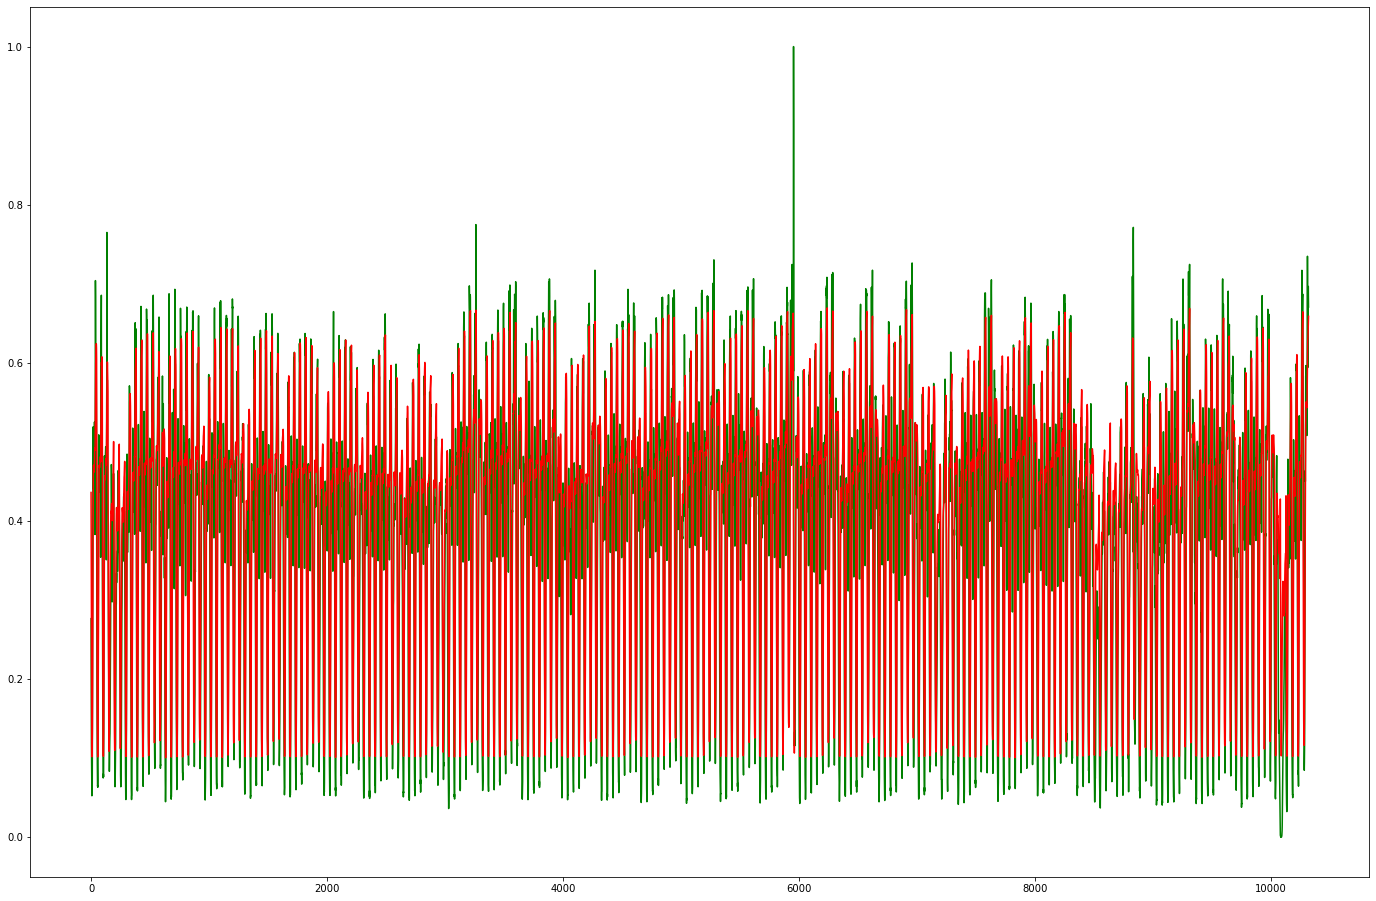

In [83]:
plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')

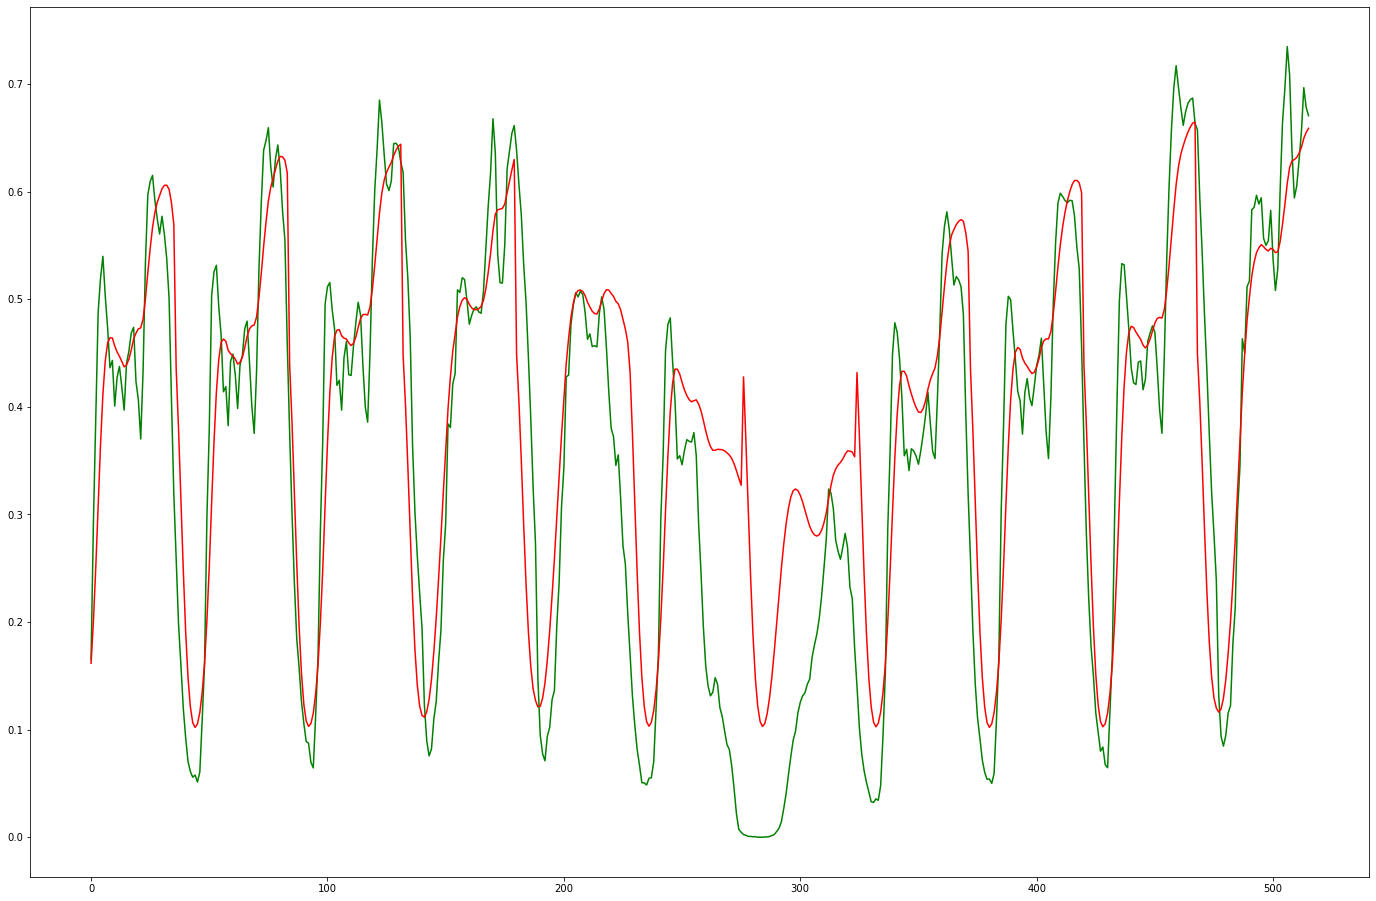

In [84]:
# partial plot
part = 0.05
plt.figure(figsize=(24,16))
plt.plot(testing_dataset[int(len(testing_dataset) * (1-part)):], color='green')
plt.plot(testing_pred[int(len(testing_dataset) * (1-part)):], color='red')

# Outlier detection result


In [85]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    

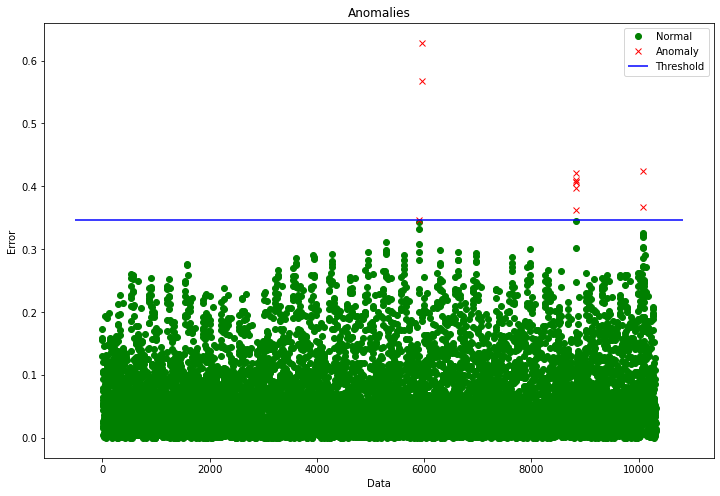

In [86]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

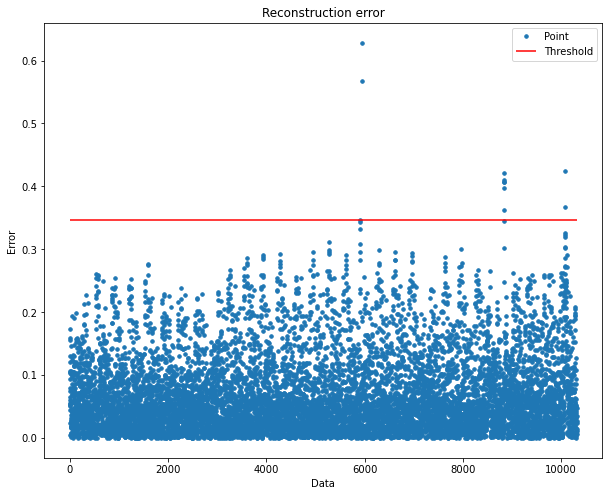

In [87]:
viz.draw_error(error, threshold)

In [88]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)


,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.159586,0
1,2014-07-01 00:30:00,8127,0.172770,0
2,2014-07-01 01:00:00,6210,0.156514,0
3,2014-07-01 01:30:00,4656,0.130162,0
4,2014-07-01 02:00:00,3820,0.094292,0


Text(0.5, 1.0, 'Time Series of value by date time')

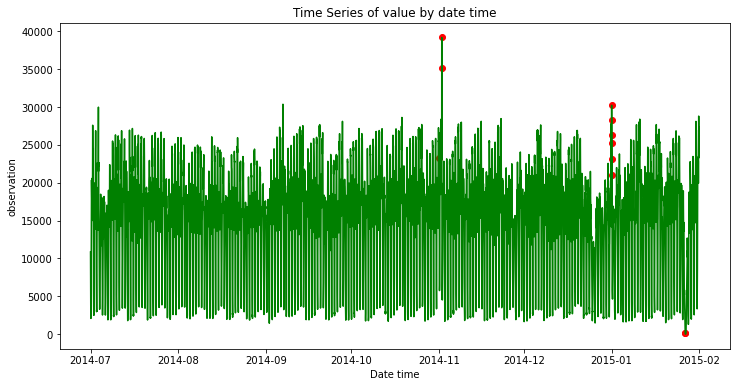

In [89]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

# deeper into anormaly

In [93]:
adf.columns

Index(['Datetime', 'observation', 'error', 'anomaly'], dtype='object')

In [95]:
adf['anomaly'].value_counts()

0    10309
1       11
Name: anomaly, dtype: int64

In [97]:
adf.query('anomaly == 1')

,Datetime,observation,error,anomaly
5908,2014-11-01 02:00:00,23245,0.346618,1
5954,2014-11-02 01:00:00,39197,0.628443,1
5955,2014-11-02 01:30:00,35212,0.567897,1
8834,2015-01-01 01:00:00,30236,0.407467,1
8835,2015-01-01 01:30:00,28348,0.410403,1
8836,2015-01-01 02:00:00,26264,0.406998,1
8837,2015-01-01 02:30:00,25243,0.421348,1
8838,2015-01-01 03:00:00,23117,0.397047,1
8839,2015-01-01 03:30:00,21017,0.362939,1
10080,2015-01-27 00:00:00,109,0.425220,1


In [105]:
index_anomalies = adf.query('anomaly == 1').index
index_anomalies

Int64Index([5908, 5954, 5955, 8834, 8835, 8836, 8837, 8838, 8839, 10080,
            10081],
           dtype='int64')

In [106]:
anomalies_start = [i for i in range(len(index_anomalies)) if index_anomalies[i] - index_anomalies[i-1] > 1]

In [112]:
anomalies_start_index = adf.query('anomaly == 1')['Datetime'].index[anomalies_start]

In [113]:
anomalies_start_index

Int64Index([5954, 8834, 10080], dtype='int64')

Text(0.5, 1.0, 'Time Series of value by date time')

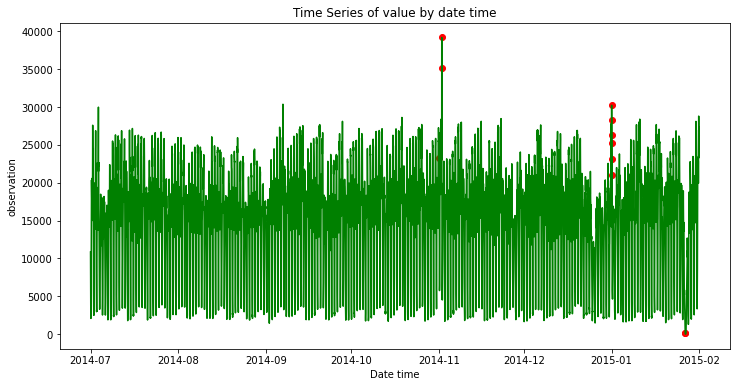

In [114]:
figure, axes = plt.subplots(figsize=(12, 6))

adf_detail = adf[anomalies_start_index[0]- 1000: anomalies_start_index[0] + 1000]

axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

In [115]:
adf_detail

,Datetime,observation,error,anomaly
4954,2014-10-12 05:00:00,4311,0.015613,0
4955,2014-10-12 05:30:00,3844,0.034304,0
4956,2014-10-12 06:00:00,3796,0.049378,0
4957,2014-10-12 06:30:00,4755,0.046388,0
4958,2014-10-12 07:00:00,4491,0.079620,0
...,...,...,...,...
6949,2014-11-22 18:30:00,26410,0.102255,0
6950,2014-11-22 19:00:00,27377,0.107205,0
6951,2014-11-22 19:30:00,26255,0.064055,0
6952,2014-11-22 20:00:00,23977,0.001085,0


In [119]:
n_plots = len(anomalies_start_index)

Text(0.5, 1.0, 'Time Series of value by date time')

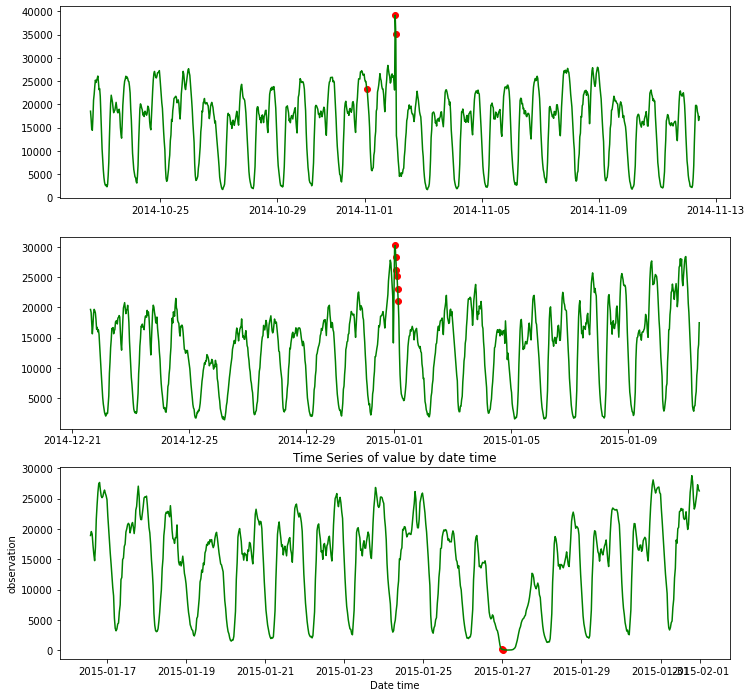

In [124]:

figure, axes = plt.subplots(n_plots,figsize=(12, 12))
window = 500

for i in range(n_plots):
    adf_detail = adf[anomalies_start_index[i]- window: anomalies_start_index[i] + window]

    axes[i].plot(adf_detail['Datetime'], adf_detail['observation'], color='g')
    anomaliesDF = adf_detail.query('anomaly == 1')
    axes[i].scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

# Modelling LSTM Prediction

Modelling LSTM. Predicting the next value in a time series based on previous values.

## Build dataset for anomaly detection

In [143]:
window_previous = 48
step = 6 # moving step
# window_prediction = 6
window_prediction = 1

In [152]:
sequence = np.array(df['scaled_value'])

In [151]:
# how many seq for training
n_sequences = int(np.floor(len(sequence) - window_previous) / step)
n_sequences

1712

In [158]:
sequence[idx * step: idx * step + window_previous].shape

(48,)

In [167]:
sequence[idx * step: idx * step + window_previous].reshape( -1).shape

(48,)

In [160]:
x[idx].shape

(48, 1)

In [203]:
# build x and y for training

x = np.ndarray( shape = (n_sequences, window_previous, 1), dtype = float)
y = np.ndarray( shape = (n_sequences, window_prediction, 1), dtype = float)

for idx in range(n_sequences):
    x[idx] = sequence[idx * step: idx * step + window_previous].reshape(-1, 1)
    y[idx] = sequence[idx * step + window_previous: idx * step + window_previous + window_prediction]

<AxesSubplot:ylabel='Count'>

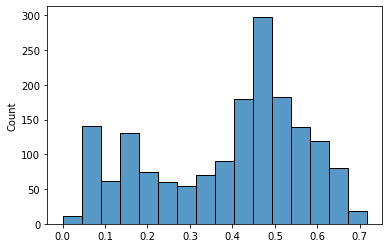

In [208]:
sns.histplot(y.reshape(-1))

In [206]:
x.shape, y.shape

((1712, 48, 1), (1712, 1, 1))

In [171]:
# y = np.ndarray(shape =(215, window_prediction,1))
# for idx, s in enumerate(y):
#     s1 = s[:window_prediction]
#     y[idx] = s1
    

In [207]:
# shift 1
x = x[:-1]
y = y[1:]
x.shape, y.shape

((1711, 48, 1), (1711, 1, 1))

In [88]:
## Split data into train and test

In [225]:
x_train, y_train, x_test, y_test = x[:int(0.8*x.shape[0])], y[:int(0.8*y.shape[0])], x[int(0.8*x.shape[0]):], y[int(0.8*y.shape[0]):]

In [226]:
y.shape[0]

1711

In [227]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1368, 48, 1), (1368, 1, 1), (343, 48, 1), (343, 1, 1))

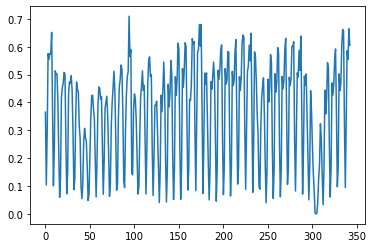

In [230]:
plt.plot(y_test.reshape(-1))

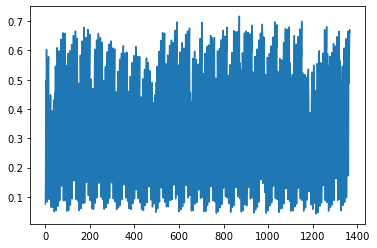

In [228]:
plt.plot(y_train.reshape(-1))

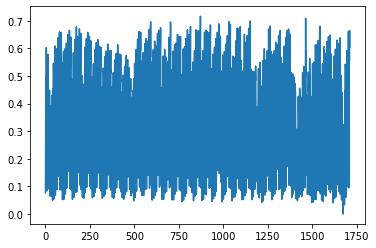

In [229]:
plt.plot(y.reshape(-1))

<AxesSubplot:ylabel='Count'>

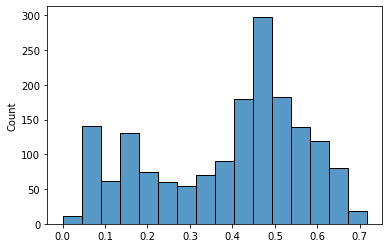

In [215]:
sns.histplot(y.reshape(-1))

<AxesSubplot:ylabel='Count'>

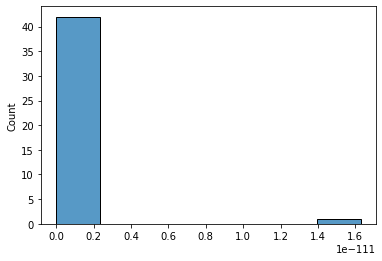

In [212]:
sns.histplot(y_test.reshape(-1))

In [119]:
## Plot dataset

<AxesSubplot:ylabel='Count'>

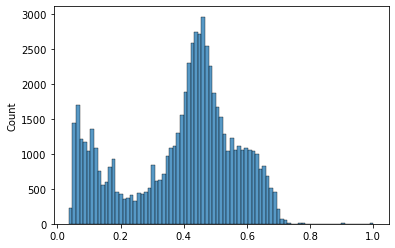

In [231]:
sns.histplot(x_train.reshape(-1))

<AxesSubplot:ylabel='Count'>

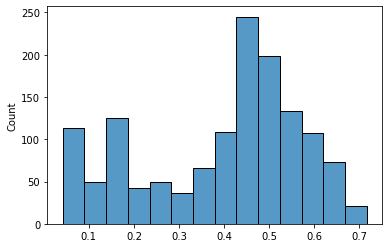

In [232]:
sns.histplot(y_train.reshape(-1))

Text(0.5, 1.0, 'Time Series of value by date time')

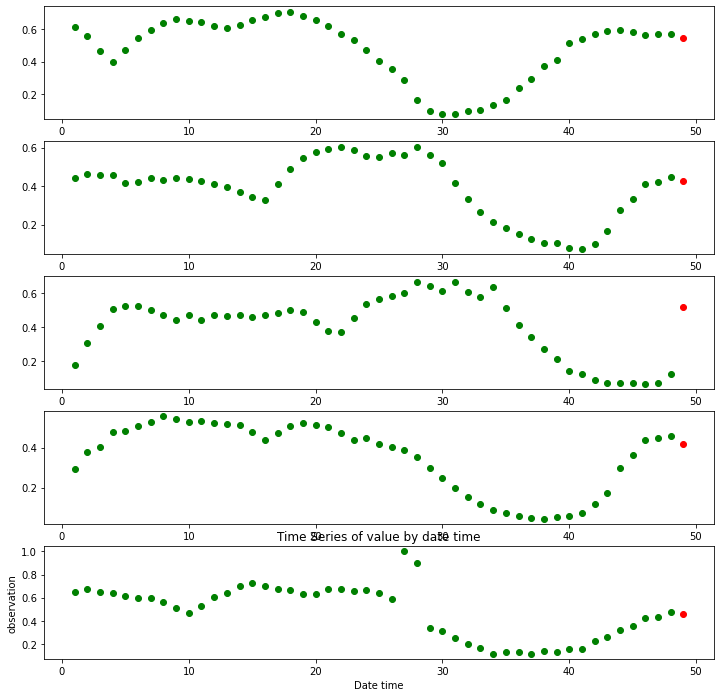

In [233]:
import random
n_plots = 5
figure, axes = plt.subplots(n_plots,figsize=(12, 12))

for i in range(n_plots):
    
    idx_ = random.randint(0, x_train.shape[0])
    axes[i].scatter(np.linspace(1,len(x_train[idx_]),len(x_train[idx_])), x_train[idx_].reshape(-1), color='g')
    # axes[i].scatter(np.linspace(1,len(x_train[idx_])), x_train[idx_].reshape(-1), color='g')
    axes[i].scatter(len(x_train[idx_]) + 1, y_train[idx_].reshape(-1), color='r')
    # axes[i].scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

## Build model

In [91]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [234]:
# same model as before

metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(window_previous, 1), return_sequences=False))

model.add(TimeDistributed(Dense(1, activation='relu')))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

AssertionError: 

## model from an  example

In [254]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(window_previous,1)))
model.add(RepeatVector(window_prediction))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

# need mae, not mse

model.compile(optimizer='adam', loss='mae')
model.summary()



Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 1, 100)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 1, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [255]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1368/1368 [==============================] - 7s 5ms/step - loss: 0.2540
Epoch 2/10
1368/1368 [==============================] - 5s 3ms/step - loss: 0.1459
Epoch 3/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.1274
Epoch 4/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.1076
Epoch 5/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.1087
Epoch 6/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.1297
Epoch 7/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.1147
Epoch 8/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.1031
Epoch 9/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.0962
Epoch 10/10
1368/1368 [==============================] - 5s 4ms/step - loss: 0.0992


### Evaluate the model

In [256]:
y_pred = model.predict(x_test)

In [257]:
y_pred.shape

(343, 1, 1)

In [258]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [259]:
mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))

0.10444378391008055

Text(0.5, 1.0, 'Time Series of value by date time')

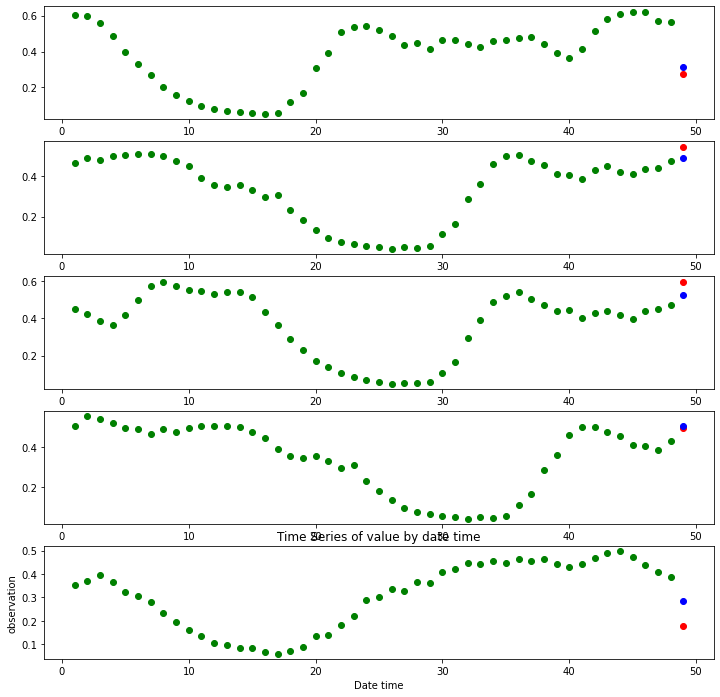

In [261]:
# check random results visually

import random
n_plots = 5
figure, axes = plt.subplots(n_plots,figsize=(12, 12))

for i in range(n_plots):
    
    idx_ = random.randint(0, x_test.shape[0])
    axes[i].scatter(np.linspace(1,len(x_test[idx_]),len(x_test[idx_])), x_test[idx_].reshape(-1), color='g')
    # axes[i].scatter(np.linspace(1,len(x_train[idx_])), x_train[idx_].reshape(-1), color='g')
    axes[i].scatter(len(x_test[idx_]) + 1, y_test[idx_].reshape(-1), color='r')
    
    axes[i].scatter(len(x_test[idx_]) + 1, y_pred[idx_].reshape(-1), color='b')
    # axes[i].scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

## A model from autoencoder

In [93]:
# A model refer to LSTM auto encoder
# May notable to get a good fit
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(window_previous,1)))
model.add(RepeatVector(window_prediction))
model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(LSTM(100, activation='relu'))
model.add(TimeDistributed(Dense(1)))

# model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 1, 100)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
171/171 [==============================] - 3s 20ms/step - loss: nan
Epoch 2/100
171/171 [==============================] - 1s 4ms/step - loss: nan
Epoch 3/100
171/171 [==============================] - 1s 4ms/step - loss: nan
Epoch 4/100
171/171 [==============================] - 1s 4ms/step - loss: nan
Epoch 5/100
171/171 [==============================] - 1s 4ms/step - loss: nan
Epoch 6/100
171/171 [==============================] - 1s 4ms/step - loss: nan
Epoch 7/100
 96/171 [===============>..............] - ETA: 0s - loss: nan

KeyboardInterrupt: 

## Build Model 2

In [102]:
# A model refer to LSTM auto encoder
# May notable to get a good fit
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_previous,1)))
# model.add(RepeatVector(window_prediction))
# model.add(LSTM(100, activation='relu', return_sequences=True))

# model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

# model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [105]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((171, 48, 1), (171, 1, 1), (43, 48, 1), (43, 1, 1))

In [103]:

model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

ValueError: Error when checking target: expected dense_18 to have 2 dimensions, but got array with shape (171, 1, 1)